In [1]:
import pandas as pd
from tqdm import tqdm
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from metrics import Metric
from rank_fuser import RankFuser
from statistics_computation import compute_statistics

import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

bge_reranker = Metric.get_metric("bge_reranker")
# roberta_nli = Metric.get_metric("roberta_nli")

In [3]:
rf_bge = RankFuser(config={"bge_reranker": 1.0})
# rf_roberta = RankFuser(config={"roberta_nli": 1.0})
import random

FILE = "experiments/query_expansions/results/bge_title_search_results.jsonl"
SAMPLE_SIZE = 100

# First, count the total number of lines in the file
with open(FILE, "r") as f:
    total_lines = sum(1 for _ in f)

# Randomly select 100 line indices
random_indices = set(random.sample(range(total_lines), SAMPLE_SIZE))

# Read only the selected lines
data = []
with open(FILE, "r") as f:
    for i, line in enumerate(f):
        if i in random_indices:
            row_data = json.loads(line)
            row_data["results"] = row_data["results"][:200]
            data.append(row_data)
        if len(data) == SAMPLE_SIZE:
            break

print(f"Read {len(data)} random lines from the file.")
print(f"Results length: {len(data[0]['results']) if data else 0}")

Read 100 random lines from the file.
Results length: 200


In [4]:
query = pd.Series(data[0]['record'])
results = pd.DataFrame(data[0]['results'])
print(query)
print(results.columns)

source_doi                      10.1146/annurev.astro.41.011802.094844
sent_original        This is in contrast to the situation for older...
sent_no_cit          This is in contrast to the situation for older...
sent_idx                                                           608
citation_dois                     ['10.1086/117396', '10.1086/187664']
pubdate                                                       20030101
resolved_bibcodes       ['1995AJ....109.1682L', '1994ApJ...436L.189M']
sent_cit_masked      This is in contrast to the situation for older...
expanded_query                                                    None
dtype: object
Index(['doi', 'pubdate', 'citation_count', 'text', 'metric'], dtype='object')


In [5]:
from metrics import Metric
bge = Metric.get_metric("bge_reranker")


In [6]:
scores = bge(query, results)

In [7]:
print(type(scores))
print(len(scores))
print(scores[0])

<class 'pandas.core.series.Series'>
200
3.4815762042999268


In [9]:
reranked = rf_bge.rerank(data)


Reranking results: 100%|██████████| 100/100 [05:41<00:00,  3.42s/it]


In [10]:
stats = compute_statistics(reranked)
print(stats.keys())

Computing statistics: 100%|██████████| 100/100 [00:00<00:00, 2968.68it/s]

dict_keys(['hitrate', 'iou', 'recall'])


In [14]:
stats['hitrate'][99]

np.float64(0.93)

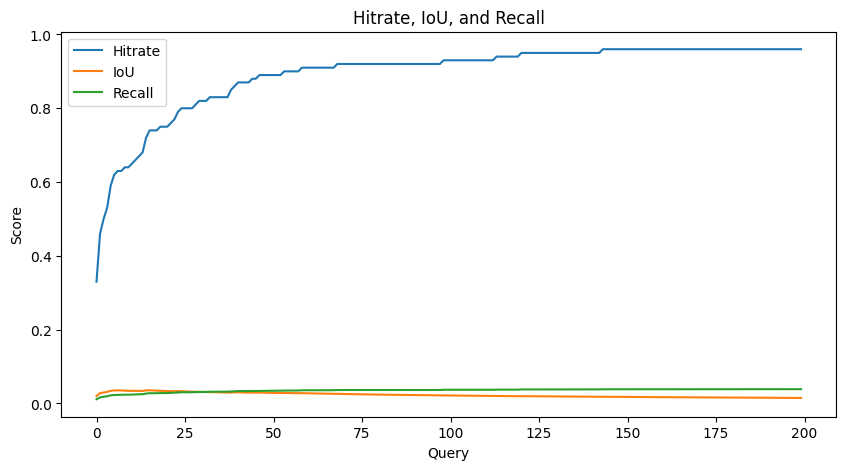

In [13]:
# plot hitrate, iou, and recall on the same plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(stats['hitrate'], label='Hitrate')
plt.plot(stats['iou'], label='IoU')
plt.plot(stats['recall'], label='Recall')
plt.xlabel('Query')
plt.ylabel('Score')
plt.title('Hitrate, IoU, and Recall')
plt.legend()
plt.show()


In [15]:
original_stats = compute_statistics(data)

Computing statistics: 100%|██████████| 100/100 [00:00<00:00, 3553.14it/s]


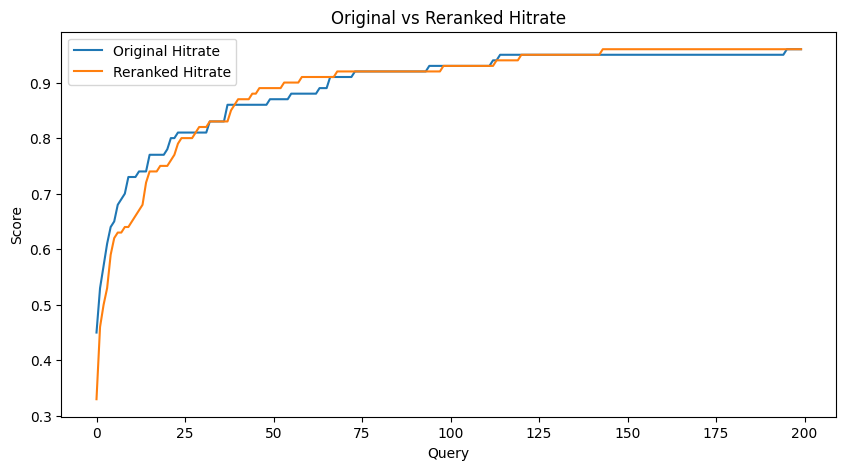

In [16]:
# plot original_stats['hitrate'] against stats['hitrate']
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(original_stats['hitrate'], label='Original Hitrate')
plt.plot(stats['hitrate'], label='Reranked Hitrate')
plt.xlabel('Query')
plt.ylabel('Score')
plt.title('Original vs Reranked Hitrate')
plt.legend()
plt.show()
    